# 3REQ system

Requirement analysis system.

The flow is presented in the following figure: 

<img src="flow.png" alt="drawing" width="700"/>

Summary:
1. Extract sections that contain words like "latency"
2. Find if they resemble requirements or not
3. Check if they are specific kinds of requirements (like signalling)
4. Write new requirements based on the text in these sections. 

In [1]:
# Importing required libraries

# docx2python is used to extract text, images, tables, and other data from .docx files
from docx2python import docx2python

# os module provides functions for interacting with the operating system
import os

# numpy is used for mathematical operations on large, multi-dimensional arrays and matrices
import numpy as np

# pandas is used for data manipulation and analysis
import pandas as pd

# TSNE from sklearn.manifold is used for dimensionality reduction
from sklearn.manifold import TSNE

# matplotlib.pyplot is used for creating static, animated, and interactive visualizations in Python
import matplotlib.pyplot as plt

# SentenceTransformer is used for training and using transformer models for generating sentence embeddings
from sentence_transformers import SentenceTransformer

# tqdm is used to make loops show a smart progress meter
from tqdm import tqdm

# torch is the main package in PyTorch, it provides a multi-dimensional array with support for autograd operations like backward()
import torch

# AutoModelForCausalLM, AutoTokenizer, pipeline are from the transformers library by Hugging Face which provides state-of-the-art machine learning models like BERT, GPT-2, etc.
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

# euclidean distance and cosine distance
from scipy.spatial import distance

In [2]:
# suppress warnings
import warnings

warnings.filterwarnings("ignore")

## Step 1: List the documents's sections with "latency"

In the first step, we go through the documents in the folder "input_standards" and we extract which sections of these documents contain th word "latency". We store the results in a dictionary.

In [53]:
def extractLatencySections(doc):
    strSectionTitle = ""
    dictSections = {}
    listLatency = []
    skippedSections = 0

    doc_result = docx2python(doc,paragraph_styles = True, html=True)

    # we iterate over all lines
    # look for the section titles (which have the tag <h1>, <h2>, <h3>, etc.)
    # then we add the content of each section to the dictionary
    # and if there is a word "latency" somewhere in the section, we add the section title to the listLatency
    for oneLine in tqdm(doc_result.text.split('\n')):
        if "<h" in oneLine:
            strSectionTitle = oneLine
            dictSections[strSectionTitle] = []

        if strSectionTitle != "":  
            dictSections[strSectionTitle].append(oneLine)

        keywordsInLine = ["latency", "latencies", "delay", "bandwidth"]
        keywordsInSections = ["references", "introduction", "definition", "abstract", "conclusion", "acknowledgements", "appendix", "table of contents", "table of figures", "table of tables", "table of contents", "table of figures", "table of tables", "bibliography", "index", "glossary", "list of figures", "list of tables", "list of abbreviations", "list of symbols", "list of terms", "list of equations", "list of algorithms", "list of acronyms", "list of illustrations", "list of appendices"]

        if any(word in oneLine.lower() for word in keywordsInLine) and not any(word in strSectionTitle.lower() for word in keywordsInSections): 
            listLatency.append(strSectionTitle)
        else:
            skippedSections += 1

            
    # remove the keys from the dictionary if they are not part of the listLatency
    # as we want to get only the relevant sections, i.e., the one with the word latency
    for key in list(dictSections.keys()):
        if key not in listLatency:
            del dictSections[key]

    # print("Skipped sections: ", skippedSections)

    # return the dictionary with the relevant sections
    return dictSections


In [106]:
docInputFolder = "./input_standards"

# this is the return list of all the lines in the document
lstAllLines = []

# for each .docx file in the input folder
# extract the sections with latency using the extractLatencySections function
# and print the sections
for doc in tqdm(os.listdir(docInputFolder)):    

    if doc.endswith(".docx"):
        #print(f"Processing {doc}")

        # since things can go wrong with the latency library, 
        # we use a try except block to avoid the program to stop
        try: 
            dictSections = extractLatencySections(os.path.join(docInputFolder, doc))
        
            # we list the content
            # as a long list of sections 
            for key in dictSections:

                lstOneLine = [key, doc]

                for line in dictSections[key]:
                    lstOneLine.append(line)
                    
                lstAllLines.append(lstOneLine)

        except Exception as e:
            print(f"Error with {doc}: {e}")

100%|██████████| 97/97 [04:18<00:00,  2.67s/it]


In [107]:
# model = SentenceTransformer("all-MiniLM-L6-v2")
model = SentenceTransformer("sentence-t5-large")

# list with all embeddings for the sections
lstEmbeddings = []
iCounter = 0

for oneLine in tqdm(lstAllLines):

    # the content of the section starts on the third position of the list
    sentences = oneLine[3:]

    # Sentences are encoded by calling model.encode()
    embeddings = model.encode(sentences)
    
    # Print the average embeddings for all the sentences 
    # in this section
    avg_embeddings = embeddings.mean(axis=0)
    
    lstOneLine = [oneLine[0], oneLine[1], 2, str(sentences).replace("$", "_").replace("\n", "_"), avg_embeddings]

    lstEmbeddings.append(lstOneLine)

    iCounter += 1
    # the code below is for debug only
    # in case we want to stop the loop after a certain number of iterations
    #if iCounter == 100:
    #    break

RuntimeError: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


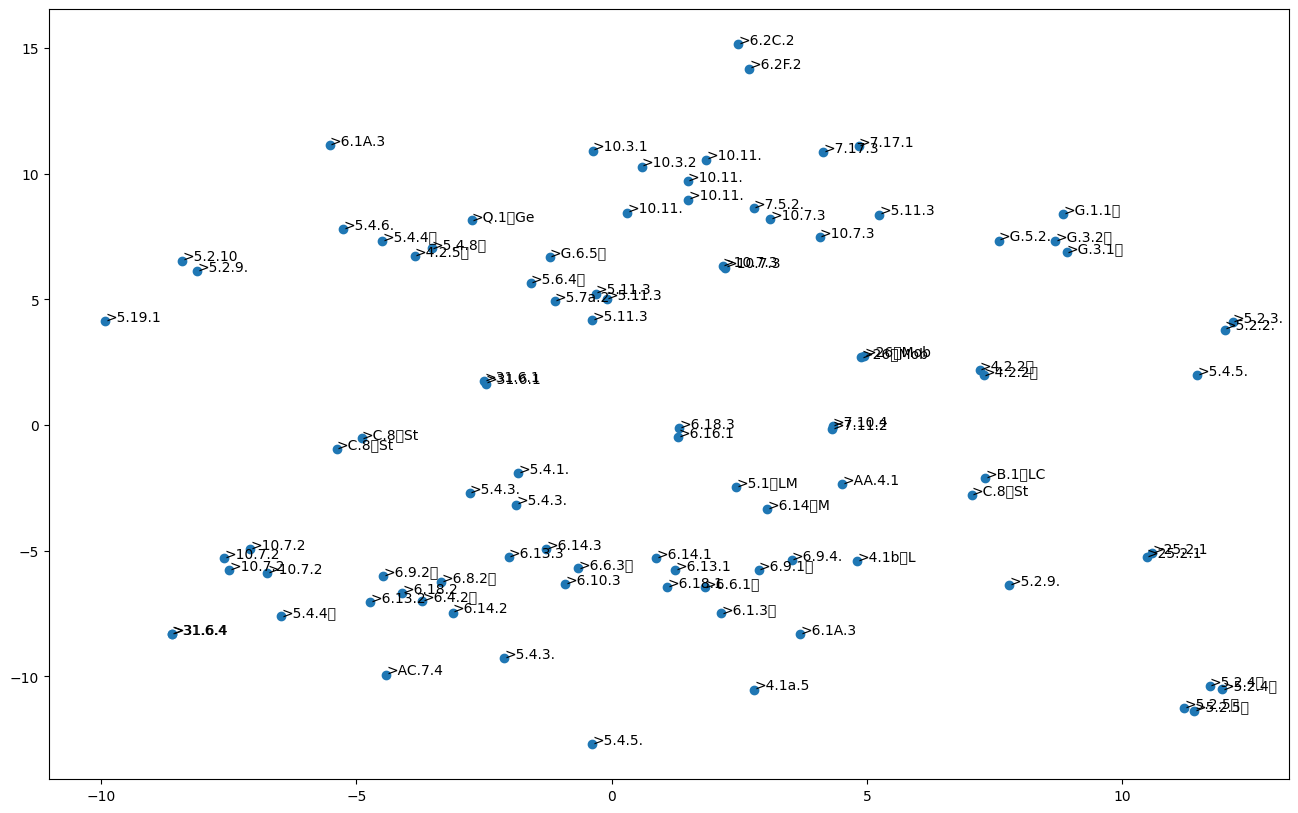

In [59]:
# let's plot these average embeddings using t-SNE

# we create a list with the embeddings
lstEmbeddingsNP = np.array([x[4] for x in lstEmbeddings])

# we use t-SNE to reduce the dimensionality of the embeddings
tsne = TSNE(n_components=2, verbose=0, perplexity=12, n_iter=300)
tsne_results = tsne.fit_transform(lstEmbeddingsNP)

# we plot the t-SNE results
plt.figure(figsize=(16,10))

plt.scatter(tsne_results[:,0], tsne_results[:,1])

# Add labels to each dot
for i, label in enumerate([x[0] for x in lstEmbeddings]):
    plt.text(tsne_results[i, 0], tsne_results[i, 1], label[3:10])


plt.show()

## Step 2: Find the relevant sections

In this step, we take the sections identified in Step 1 and we compare them to a list of right and wrong requirements. The list is stored in the file List.xlsx

In [60]:
# open the file List.xlsx using pandas
# and read the workshop NR
df = pd.read_excel("List.xlsx", sheet_name="R_NR")

# convert the dataframe to a list of lists
lstReference = df.values.tolist()

lstReference[0]

['The 5G system shall support an end-to-end latency of less than 5 ms or 10 ms, as requested by the UE initiating the communication.',
 1]

In [61]:
# list with all embeddings for the sections
lstEmbeddingsRef = []

for oneLine in tqdm(lstReference):

    # the content of the section starts on the third position of the list
    sentences = oneLine[0]

    # Sentences are encoded by calling model.encode()
    embeddings = model.encode(sentences)
    
    # Print the average embeddings for all the sentences 
    # in this section
    avg_embedding = embeddings
    
    lstOneLine = [oneLine[0], 'REF', oneLine[1], oneLine[1], avg_embedding]

    lstEmbeddingsRef.append(lstOneLine)

100%|██████████| 19/19 [00:00<00:00, 23.68it/s]


In [62]:
# concatenate the two lists
lstEmbeddingsAll = lstEmbeddings + lstEmbeddingsRef

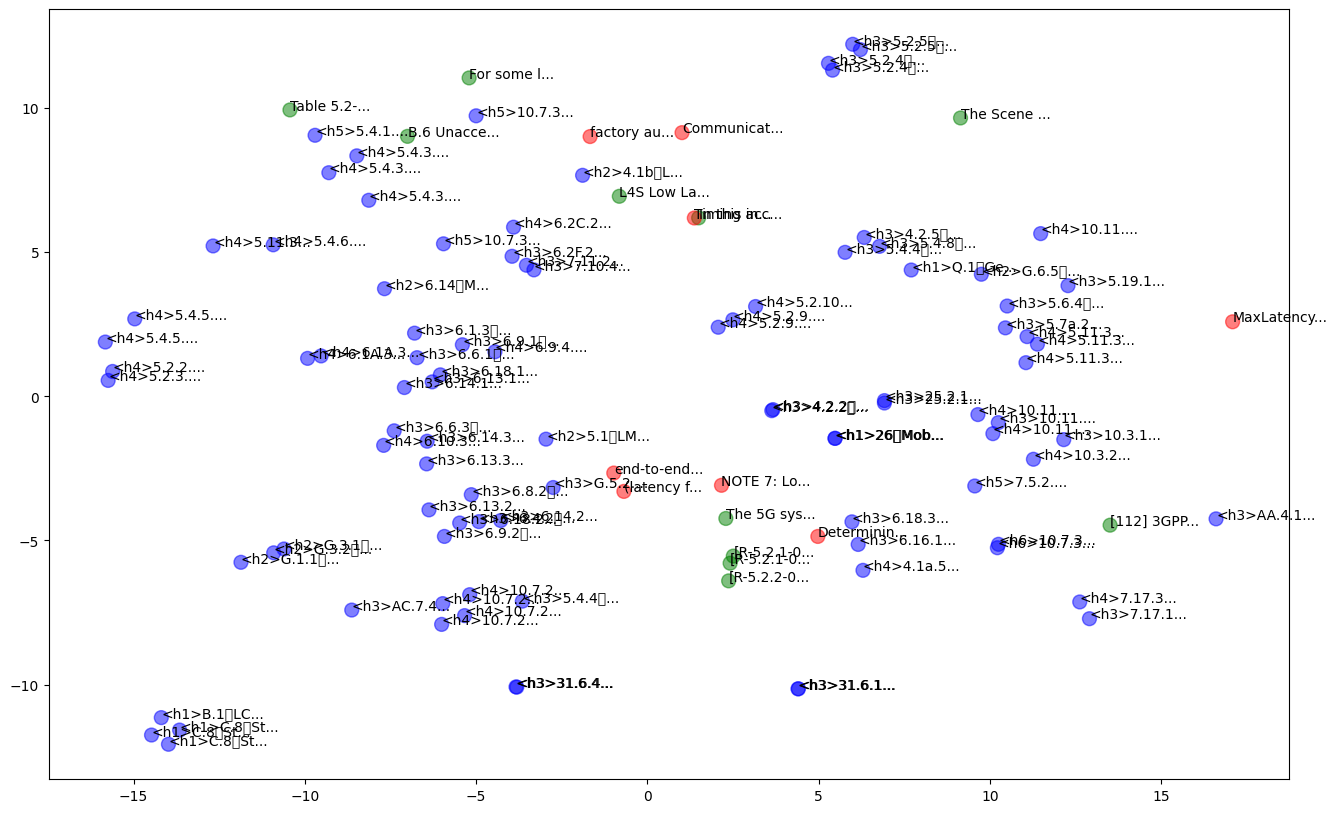

In [63]:
# let's plot these average embeddings using t-SNE

# we create a list with the embeddings
lstEmbeddingsNP = np.array([x[4] for x in lstEmbeddingsAll])

# we use t-SNE to reduce the dimensionality of the embeddings
tsne = TSNE(n_components=2, verbose=0, perplexity=12, n_iter=300)
tsne_results = tsne.fit_transform(lstEmbeddingsNP)

# Create a color map based on x[2]
color_map = {0: 'red', 1: 'green', 2: 'blue'}
colors = [color_map[x[2]] for x in lstEmbeddingsAll]

# we plot the t-SNE results
plt.figure(figsize=(16,10))

plt.scatter(tsne_results[:,0], tsne_results[:,1],c=colors, s=100, alpha=0.5)

# Add labels to each dot
for i, label in enumerate([x[0] for x in lstEmbeddingsAll]):
    plt.text(tsne_results[i, 0], tsne_results[i, 1], label[:10]+'...')


plt.show()

In [64]:
from sklearn.metrics.pairwise import euclidean_distances

# for each line in lstEmbeddings
# we calculate the euclidean distance with each line in lstEmbeddingsRef

lstDistPos = []
lstDistNeg = []

lstRelevant = []

for oneLine in tqdm(lstEmbeddings):    
    for oneLineRef in lstEmbeddingsRef:
        if oneLineRef[2] == 1:
            # euclidean distance between the two embeddings
            dist = distance.cosine(oneLine[4], oneLineRef[4])
            lstDistPos.append(dist)
        if oneLineRef[2] == 0:
            # euclidean distance between the two embeddings
            dist = distance.cosine(oneLine[4], oneLineRef[4])
            lstDistNeg.append(dist)
    
    # now calculate the average for both lists
    avgDistPos = np.mean(lstDistPos)
    avgDistNeg = np.mean(lstDistNeg)

    if avgDistPos < avgDistNeg:
        #print(f"Section {oneLine[0]} is relevant")
        # add the class to the list
        oneLine.append(1)
        lstRelevant.append(oneLine)
    else:
        #print(f"Section {oneLine[0]} is not relevant")
        # add the class to the list
        oneLine.append(0)

                

100%|██████████| 95/95 [00:00<00:00, 3216.41it/s]


In [65]:
print(f'Relevant sections: {len(lstRelevant)}')

Relevant sections: 95


In [66]:
lstEmbeddings[0]

['<h3>4.2.2\tMobile Terminated Short Message</h3>',
 '23007-i20.docx',
 2,
 '[\'\', \'a)\\tSend Routing Information for MT SMS (SMS-GMSC-&gt;HLR):\', \'\', \'\\tThe HLR returns the MSC number as for normal operation.\', \'\', \'b)\\tSend Information for MT SMS (MSC-&gt;VLR) - MAP version 2:\', \'\', \'-\\tIf the VLR has no IMSI record, or if the record is marked "Subscriber Data Not Confirmed by HLR", the VLR proceeds as follows:\', \'\', \'-\\tthe VLR returns an "Unidentified Subscriber" error. This causes the MSC to report a short message delivery failure, with cause "Unidentified Subscriber", to the SMS gateway MSC. The Gateway MSC sends a "Report SM Delivery Status" request, with a cause of "Absent Subscriber", to the HLR. This causes the HLR to set the "Mobile Station Not Reachable Flag" for the MS, as described in Technical Specifications 3GPP\\xa0TS\\xa023.040\\xa0[4] and 3GPP\\xa0TS\\xa029.002\\xa0[6]; or\', \'\', \'-\\tthe VLR performs the data restoration procedure as specifi

In [67]:
# here we save all the relevant sections to an Excel file
# and the non-relevant ones too
import pandas as pd

dfOutput = pd.DataFrame(lstEmbeddings, columns=["Section", "Document", "Class", "Content", "Embedding", "Relevance"])

dfOutput.to_excel("./output.xlsx", index=False)

## Step 3: Find which requirements are impacted

In this step, we compare the relevant sections with the existing requirements. Based on the distance, we can determine which requirements are impacted. The requirements are provided as a separete list. 

In [68]:
print(f'Percentage relevant: {len(lstRelevant)/len(lstEmbeddings)*100:.2f}%')

Percentage relevant: 100.00%


In [69]:
# read the requirements from the excel file requirements.xlsx, worksheet LR
df = pd.read_excel("List.xlsx", sheet_name="LR")

# convert to list
lstRequirements = df.values.tolist()
lstRequirements[0]

# now we calculate the embeddings for each of these requirements
lstEmbeddingsReq = []

for oneLine in tqdm(lstRequirements):
    
        # the content of the section starts on the third position of the list
        sentences = oneLine[1]
    
        # Sentences are encoded by calling model.encode()
        embeddings = model.encode(sentences)
        
        # Print the average embeddings for all the sentences 
        # in this section
        avg_embedding = embeddings
        
        lstOneLine = [oneLine[0], 'latency', oneLine[1], oneLine[1], avg_embedding]
    
        lstEmbeddingsReq.append(lstOneLine)

100%|██████████| 38/38 [00:01<00:00, 25.39it/s]


In [71]:
# now we calculate the euclidean distance between the requirements and the sections
# that are relevant
lstDist = []
lstRelevantDist = []

for oneLine in tqdm(lstRelevant):
    for oneLineReq in lstEmbeddingsReq:
        # euclidean distance between the two embeddings
        dist = distance.cosine(oneLine[4], oneLineReq[4])
        lstDist.append([oneLine[0], oneLine[1], oneLineReq[0], dist, oneLine[3]])

# now we sort the list by the distance
lstDist.sort(key=lambda x: x[2])

# and we print them
for i in range(len(lstDist)):
    print(f"Section {lstDist[i][0]} is close to requirement {lstDist[i][2]} with distance {lstDist[i][3]:.2f}")
    # add this to a list
    lstRelevantDist.append([lstDist[i][0], lstDist[i][1], lstDist[i][2], lstDist[i][3], lstDist[i][4]])

# save the list to an Excel file
dfOutput = pd.DataFrame(lstRelevantDist, columns=["Section", "Document", "Requirement", "Distance", "Content"])

# sort it by section and document
dfOutput = dfOutput.sort_values(by=["Section", "Document"])

dfOutput.to_excel("./output_requirements_distances_b.xlsx", index=False)

100%|██████████| 95/95 [00:00<00:00, 2646.65it/s]


Section <h3>4.2.2	Mobile Terminated Short Message</h3> is close to requirement LR1_signalling with distance 0.23
Section <h3>5.2.4	Procedures in the SGSN</h3> is close to requirement LR1_signalling with distance 0.23
Section <h3>5.2.5	Procedures in the MME</h3> is close to requirement LR1_signalling with distance 0.22
Section <h3>25.2.1	General</h3> is close to requirement LR1_signalling with distance 0.23
Section <h1>26	Mobile terminated CS service delivery via an alternative MME in MME pool</h1> is close to requirement LR1_signalling with distance 0.22
Section <h3>31.6.1	General</h3> is close to requirement LR1_signalling with distance 0.24
Section <h3>31.6.4	Restoration of PFCP sessions associated with an FQ-CSID, Group ID or PGW-C/SMF IP Address</h3> is close to requirement LR1_signalling with distance 0.28
Section <h3>4.2.2	Mobile Terminated Short Message</h3> is close to requirement LR1_signalling with distance 0.23
Section <h3>5.2.4	Procedures in the SGSN</h3> is close to requir

In [72]:
# average the distance in dfOutput per section, document and requirement
dfOutput["Distance"] = dfOutput["Distance"].astype(float)
dfGrouped = dfOutput.groupby(["Section", "Document", "Requirement", "Content"])

#convert dfGrouped to a dataframe
dfGrouped = dfGrouped.agg({"Distance": "mean"}).reset_index()

dfGrouped.to_excel("./output_requirements_distances_g.xlsx", index=False)

In [73]:
# now check the minimum distance per section and document
dfGrouped = dfGrouped.sort_values(by=["Section", "Document", "Distance"])

dfGrouped = dfGrouped.groupby(["Section", "Document"]).first().reset_index()

dfGrouped.to_excel("./output_requirements_distances_g_min.xlsx", index=False)

In [74]:
# now we turn this into a list of lists
lstRelevantDist = dfGrouped.values.tolist()

print(len(lstRelevantDist))

95


In [75]:
# convert to dataframe and save to excel lstRelevantDist
dfRelevantDist = pd.DataFrame(lstRelevantDist, columns=["Section", "Document", "Requirement", "Distance", "Content"])

dfRelevantDist.to_excel("./output_requirements_temp.xlsx", index=False)

## Step 4: Check if the requirements exist in the database

In this step, we check if the text that we identified so far is covered by the requirements that exist in the database. We use the sentence transformers to get the embeddings of the text and then we compare them to the existin sections. 

In [76]:
# read the requirements from the Excel file
dfRelevantSections = pd.read_excel("./output_requirements_temp.xlsx")

lstRelevantSections = dfRelevantSections.values.tolist()

In [77]:
lstRelevantSections[0]

['<h1>26\tMobile terminated CS service delivery via an alternative MME in MME pool</h1>',
 '23007-i20.docx',
 'LR2_payload',
 '[\'\', \'This procedure is an optional feature for VLR and MME. It enables the network to continue delivering mobile terminated CS services to UEs via an alternative MME in the MME pool where the UE is located when the MME to which the UE was registered fails without restart or fails for a long duration.\', \'\', \'NOTE 1:\\tUEs in idle mode are not aware of an MME failure until they need to send some uplink data or signalling (e.g. a periodic Tracking Area Update) or until they are forced to re-attach e.g. via the network trigerred service restoration procedure. Without support of the procedure defined in this clause, UEs that remain under LTE may not be able to receive mobile terminated CS services for a long duration after an MME failure without restart or a long MME failure.\', \'\', \'The following requirements shall apply if the VLR and MME support this f

In [78]:
model = SentenceTransformer("sentence-t5-large")

# list with all embeddings for the sections
lstRelevantEmbeddings = []
iCounter = 0

for oneLine in tqdm(lstRelevantSections):

    # the content of the section starts on the third position of the list
    sentences = oneLine[3]

    # Sentences are encoded by calling model.encode()
    embeddings = model.encode(sentences)
    
    # Print the average embeddings for all the sentences 
    # in this section
    # avg_embedding = np.mean(embeddings, axis=0)
    
    lstOneLine = [oneLine[0], oneLine[1], 2, str(sentences).replace("$", "_").replace("\n", "_"), embeddings]

    lstRelevantEmbeddings.append(lstOneLine)

    iCounter += 1

100%|██████████| 95/95 [00:04<00:00, 23.13it/s]


In [79]:
# now, read the requirements from the requirements database, file 20_requirements.xlsx
dfTRequirements = pd.read_excel("20_requirements.xlsx")

# convert to list
lstTRequirements = dfTRequirements.values.tolist()

In [80]:
lstTRequirements[0]

['Req_1',
 'Regarding support for infrastructure protection of electrical transmission, the 5G system shall support an end-to-end latency of less than 5 ms or 10 ms, as requested by the UE initiating the communication. ',
 'NOTE 1: This requirement relates to TS 22.104, chapter 5.6C Support for infrastructure protection of electrical transmission.\nNOTE 2: Whether the end-to-end latency is 5 ms or 10 ms depends on the applied voltage level. \nNOTE 3: The end-to-end latency is between two UEs, including two wireless links.',
 'Payload',
 nan]

In [81]:
# make the embeddings
model = SentenceTransformer("sentence-t5-large")

# list with all embeddings for the sections
lstTRequirementsEmbeddings = []
iCounter = 0

for oneLine in tqdm(lstTRequirements):

    # the content of the section starts on the requirement text
    sentences = oneLine[1]

    # Sentences are encoded by calling model.encode()
    embeddings = model.encode(sentences)
    
    # Print the average embeddings for all the sentences 
    # in this section
    #avg_embedding = np.mean(embeddings, axis=0)
    
    lstOneLine = [oneLine[0], oneLine[1], 2, str(sentences).replace("$", "_").replace("\n", "_"), embeddings]

    lstTRequirementsEmbeddings.append(lstOneLine)

    iCounter += 1

100%|██████████| 20/20 [00:00<00:00, 27.25it/s]


In [84]:
# average the embeddings for all the lstTRequirementsEmbeddings
lstTRequirementsEmbeddingsNP = np.array([x[4] for x in lstTRequirementsEmbeddings])

tRequirementsAvgEmbeddings = np.mean(lstTRequirementsEmbeddingsNP, axis=0)

In [99]:
# now, calculate the average distance of all the relevant sections to the average requirements
lstDist = []

for oneLine in tqdm(lstRelevantEmbeddings):
    # euclidean distance between the two embeddings
    dist = distance.cosine(oneLine[4], tRequirementsAvgEmbeddings)
    lstDist.append([oneLine[0], oneLine[1], dist, oneLine[3]])

# now we sort the list by the distance
lstDist.sort(key=lambda x: x[3])
    

100%|██████████| 95/95 [00:00<00:00, 9095.57it/s]


In [101]:
lstDist[10]

['<h3>6.18.1\tGeneral</h3>',
 '23288-i20.docx',
 0.12833312352660764,
 '[\'\', \'Clause\\xa06.18 describes how NWDAF can provide E2E data volume transfer time analytics, in the form of statistics or predictions or both, to a service consumer. NWDAF collects E2E data volume transfer time related input data from 5GC NFs, OAM and AF. The consumer can either subscribe to analytics notifications (i.e. a Subscribe-Notify model) or request a single notification (i.e. a Request-Response model).\', \'\', \'The E2E data volume transfer time refers to a time delay for completing the transmission of a specific data volume from UE to AF, or from AF to UE. If a target number of repeating data transmissions or a target time interval between data transmissions is given, the E2E data volume transfer time can be provided as an average value of every data volume transfer time within the Analytics target period. The E2E data volume transfer time analytics may be used to assist an AF hosting AI/ML-based se

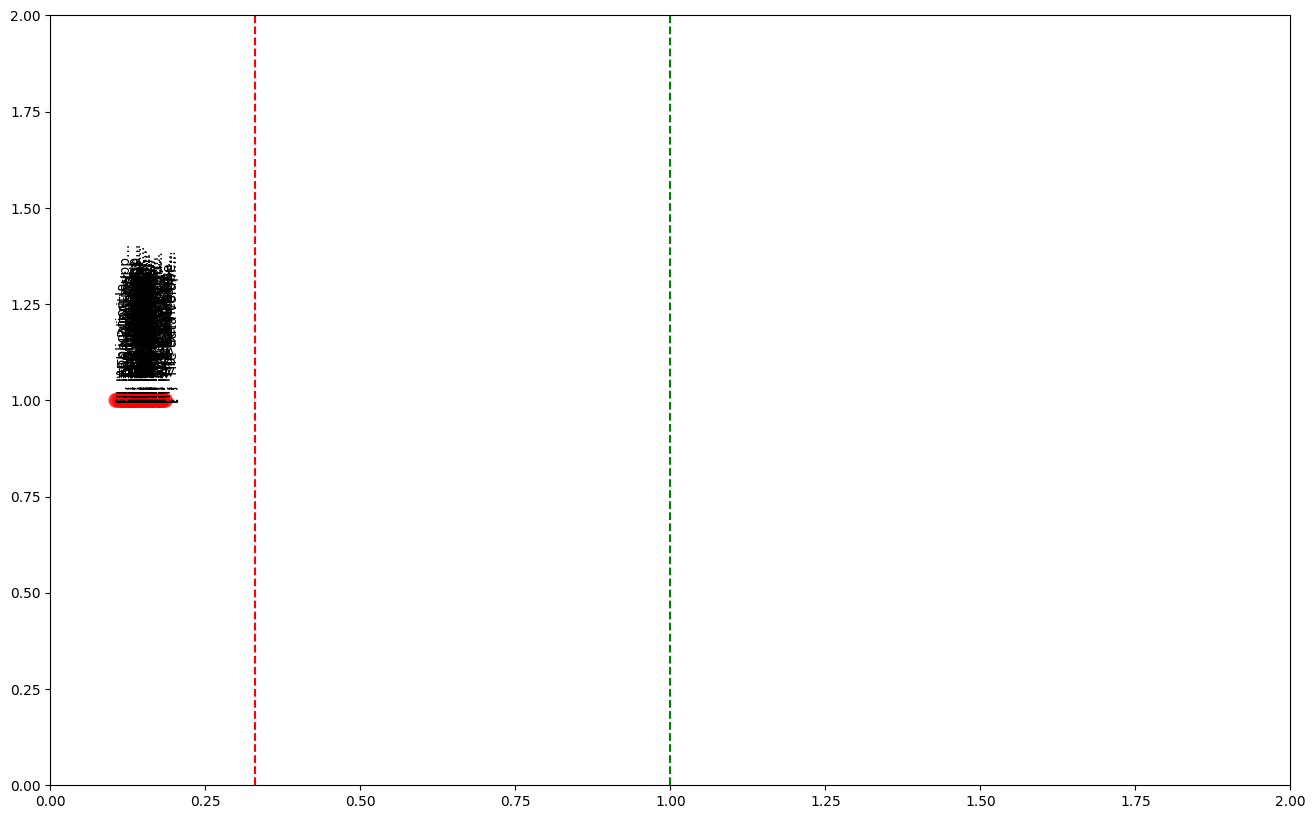

In [105]:
# Visualize the results using the scatter plot, where
# the x-axis is the distance to the average requirement
# the y-axis is always 1
# the color is red for the requirements

# Create a color map based on x[2]
color_map = {0: 'red', 1: 'green', 2: 'blue'}
colors = [color_map[0] for x in lstDist]

# we plot the t-SNE results
plt.figure(figsize=(16,10))

plt.scatter([x[2] for x in lstDist], [1 for x in lstDist], c=colors, s=100, alpha=0.5)

# Add labels to each dot
for i, label in enumerate([x[3] for x in lstDist]):
    plt.text([x[2] for x in lstDist][i], 1, label[:20]+'...', rotation='vertical')

# Add vertical lines at 0.33 and 1.0
plt.axvline(x=0.33, color='r', linestyle='--')
plt.axvline(x=1.0, color='g', linestyle='--')

# Set the limits of the x-axis
plt.xlim(0, 2)
plt.ylim(0, 2)

plt.show()

In [96]:
# now we separate them into three lists:
# - with distance below 0.33 -- these requirements are covered
# - with distance between 0.33 and 1.0 -- these requirements are partially covered
# - with distance above 1.0 -- these requirements are not covered

lstCovered = []
lstPartiallyCovered = []
lstNotCovered = []

for oneLine in lstDist:
    if oneLine[2] < 0.33:
        lstCovered.append(oneLine)
    elif oneLine[2] < 1.0:
        lstPartiallyCovered.append(oneLine)
    else:
        lstNotCovered.append(oneLine)

## Step 5: create requirements based on each of these sections

In the last step, we create new requirements based on the sections identified in the previous steps.

In [48]:
torch.random.manual_seed(0)

modelInstr = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3-mini-4k-instruct", 
    device_map="cuda", 
    torch_dtype="auto", 
    trust_remote_code=True, 
)
tokenizerInstr = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct")

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-4k-instruct:
- configuration_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-4k-instruct:
- modeling_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
`flash-attention` package not found, consider installing for better performance: No module named 'flash_attn'.
Current `flash-attenton` does not support `window_size`. Either upgrade or use `attn_implementation='eager'`.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [49]:
def createRequirement(content, type, model, tokenizer):

    content1 = content.split(",")
    content1 = [x for x in content1[1:] if x not in ['', " ''", " '']"]]
    content_str = " ".join(content1)
    
    strContent = f"Based on this : {content_str[:200]}. Write the requirement in the following format 'The {type} of the system shall ' "

    messages = [
        {"role": "user", "content": strContent},
    ]

    pipe = pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
    )

    generation_args = {
        "max_new_tokens": 500,
        "return_full_text": False,
        "temperature": 0.0,
        "do_sample": False,
    }

    output = pipe(messages, **generation_args)
    
    return output[0]['generated_text']

In [51]:
lstPartiallyCovered[0]

['<h3>6.27.2\tDescription</h3>',
 '23700-60-i00.docx',
 0.38694578,
 "['', 'RT (Round-Trip) latency requirement is the latency requirements between UE and N6 termination point at the UPF, as defined in SP-211646. To provide good service experience for users, the XR services with real-time interaction typically require very low RT latency (RT latency refers to the remaining part of the end-to-end motion-to-photon (MTP) delay excluding the processing/rending time at the UE and server side). Thus, it is necessary to study how to meet the very low RT latency requirements in 5GS. But the challenge is how to meet the very low Round-Trip latency requirement with a variable or unequal uplink/downlink latency. Since the AF lacks dynamic information of the current UL/DL situation, it is difficult for AF to split the RT latency requirement into UL and DL delay requirements in an optimized way. It is assumed that the AF to provide the RT latency requirements to 5GC.', '', 'The solution is based on

In [53]:
from tqdm import tqdm

# for every requirement from the list, we generate a requirement
# and we add it to the list

lstGenerated = []
iCounter = 0

for oneLine in tqdm(lstPartiallyCovered):
    iCounter += 1
    if (len(oneLine[3]) < 10000):
        strRequirement = createRequirement(oneLine[3], oneLine[2], modelInstr, tokenizerInstr)
        lstGenerated.append([oneLine[0], oneLine[1], oneLine[2], oneLine[3], oneLine[4], strRequirement])
    if iCounter % 10 == 0:
        # convert the list to a dataframe and save to excel
        dfOutput = pd.DataFrame(lstGenerated, columns=["Section", "Document", "Requirement type", "Content", "Distance", "Generated requirements"])
        dfOutput.to_excel("./output_partially_covered_generated_cont.xlsx", index=False)

  0%|          | 0/873 [00:00<?, ?it/s]You are not running the flash-attention implementation, expect numerical differences.


In [ ]:
dfOutput = pd.DataFrame(lstGenerated, columns=["Section", "Document", "Requirement type", "Content", "Distance", "Generated requirements"])
dfOutput.to_excel("./output_partially_covered_generated.xlsx", index=False)

In [ ]:
# check which GPUs are available 
import torch
torch.cuda.get_device_name(1)